In [1]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"reddyrohit45","key":"5656ffe6af932b0b012905545b4b6d6a"}'}

In [2]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
# !chmod 600 ~/.kaggle/kaggle.json

In [3]:
!kaggle datasets download -d salader/dogs-vs-cats

Dataset URL: https://www.kaggle.com/datasets/salader/dogs-vs-cats
License(s): unknown
100% 1.06G/1.06G [00:11<00:00, 63.2MB/s]
100% 1.06G/1.06G [00:11<00:00, 96.2MB/s]


In [4]:
import zipfile
zip_ref = zipfile.ZipFile('/content/dogs-vs-cats.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [5]:
import tensorflow as tf
from tensorflow import keras
from keras import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, BatchNormalization, Dropout

What this code does overall:

Reads images from /content/train

Automatically labels them based on folders

Groups them into batches of 32

Resizes each to 256×256 pixels

Returns a TensorFlow dataset ready for training **bold text**

Basically, 'inferred' says:

**“Hey Keras, just look at my folders, sort them alphabetically, and assign class numbers for me.”**

In [6]:
train_ds = keras.utils.image_dataset_from_directory(
    directory = '/content/train',
    labels = 'inferred',
    label_mode = 'int',
    batch_size = 32,
    image_size = (256,256)
)

validation_ds = keras.utils.image_dataset_from_directory(
    directory = '/content/test',
    labels = 'inferred',
    label_mode = 'int',
    batch_size = 32,
    image_size = (256,256)
)

Found 20000 files belonging to 2 classes.
Found 5000 files belonging to 2 classes.


**This function takes an image, scales its pixel values from 0–255 to 0–1, converts it into a floating-point format for the neural network, and sends it back with the label.**

In [7]:
from keras.src.utils.dataset_utils import labels_to_dataset

def process(image, label):
  image = tf.cast(image/255, tf.float32)
  return image,label
train_ds = train_ds.map(process)
validation_ds = validation_ds.map(process)

### 📌 MaxPooling2D – Key Points

**Purpose**  
- Reduces spatial dimensions (**downsampling**) → fewer parameters & faster training.  
- Keeps strongest features (**max value**) in each region.  
- Adds robustness to small shifts in the image.  

**pool_size = (2, 2)**  
- Window size: **2×2 pixels**.  
- Common choice — halves width & height (e.g., `256×256 → 128×128`).  
- Balances size reduction and feature retention.  

**strides = 2**  
- Moves the pooling window **2 pixels at a time** (no overlap).  
- Ensures pooling covers entire feature map efficiently.  

**Effect**  
- Produces **smaller feature maps** → faster computation, less risk of overfitting.  
- Retains **important patterns** (edges, textures) from convolutions.  


**Rule of thumb in CNNs:**

* Start with fewer filters → increase filter count gradually in deeper layers.

* This matches the idea of building from simple → complex features

📌 Dense Layers: Why 128 → 64 neurons?
1. 128 and 64 represent the number of neurons in each layer.
2. Higher neurons (128) capture more complex features from the data.
3. Fewer neurons (64) refine and compress the learned features before output.
4. Acts like a funnel: many features → fewer features → final prediction.
5. These numbers are hyperparameters; you can experiment (e.g., 256→128→1).

📌 Why ReLU Activation in hidden layers?
1. ReLU (Rectified Linear Unit) is fast and avoids the vanishing gradient problem.
2. Helps the model learn complex non-linear relationships.
3. Standard choice for hidden layers in CNNs.

📌 If we use other activations instead of ReLU:
- Sigmoid: Slower, mainly used in the final layer for binary classification.
- Tanh: Works better than sigmoid but still slower than ReLU.
- Leaky ReLU / ELU: Prevents neurons from "dying" in ReLU.
- Swish / GELU: Can give slightly better results but slower to compute.


In [8]:
model = Sequential()

model.add(Conv2D(32, kernel_size = (3,3), padding = 'valid', activation = 'relu', input_shape = (256,256,3)))
model.add(MaxPooling2D(pool_size = (2,2), strides = 2))

model.add(Conv2D(64, kernel_size = (3,3), padding = 'valid', activation = 'relu'))# increase to 64 so it extract more features like curvature
model.add(MaxPooling2D(pool_size = (2,2), strides = 2))

#Dense layers expect a flat vector as input (not a 3D tensor).
model.add(Flatten())

model.add(Dense(128, activation = 'relu'))
model.add(Dense(64, activation = 'relu'))
model.add(Dense(1, activation = 'sigmoid'))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [9]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 254, 254, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 125, 125, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 246016)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    31,490,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,517,889 (120.23 MB)

 Trainable params: 31,517,889 (120.23 MB)

 Non-trainable params: 0 (0.00 B)

**In short:**

* Adam → how to adjust weights (smart learning strategy).

* Binary Crossentropy → how to measure wrongness (suitable for 0/1 labels).

* Accuracy → how good the model is performing in easy terms.

In [10]:
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [11]:
history = model.fit(train_ds, epochs = 5, validation_data = validation_ds)

Epoch 1/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 51s 69ms/step - accuracy: 0.5819 - loss: 0.8167 - val_accuracy: 0.6826 - val_loss: 0.6137
Epoch 2/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 43s 69ms/step - accuracy: 0.7468 - loss: 0.5117 - val_accuracy: 0.7584 - val_loss: 0.5133
Epoch 3/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 45s 72ms/step - accuracy: 0.8534 - loss: 0.3290 - val_accuracy: 0.7490 - val_loss: 0.7066
Epoch 4/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 46s 73ms/step - accuracy: 0.9428 - loss: 0.1532 - val_accuracy: 0.7492 - val_loss: 1.0741
Epoch 5/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 82s 74ms/step - accuracy: 0.9686 - loss: 0.0954 - val_accuracy: 0.7374 - val_loss: 1.1906


In [53]:
import cv2
test_dog = cv2.imread('/content/dog.jpg')
test_dog
# print(test_dog)

array([[[0, 1, 2],
        [0, 1, 2],
        [0, 1, 2],
        ...,
        [5, 0, 1],
        [5, 0, 1],
        [5, 0, 1]],

       [[0, 1, 2],
        [0, 1, 2],
        [0, 1, 2],
        ...,
        [3, 1, 1],
        [5, 0, 1],
        [3, 1, 1]],

       [[1, 1, 1],
        [1, 1, 1],
        [1, 1, 1],
        ...,
        [1, 1, 1],
        [3, 1, 1],
        [1, 1, 1]],

       ...,

       [[0, 0, 5],
        [0, 0, 5],
        [0, 0, 5],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 4],
        [0, 0, 4],
        [0, 0, 4],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[1, 0, 2],
        [1, 0, 2],
        [1, 0, 2],
        ...,
        [2, 0, 0],
        [2, 0, 0],
        [2, 0, 0]]], dtype=uint8)

* Conv2D (extract features)
* ↓
* BatchNorm (normalize & stabilize)
* ↓
* MaxPooling2D (reduce spatial size)


In [47]:
import pandas as pd

# Table: CNN Architecture Layer Explanation
data = [
    ["Conv2D",
     "Extracts spatial features using learnable filters (kernels). Helps detect edges, textures, shapes."],

    ["BatchNormalization",
     "Normalizes activations, speeding up training & improving stability."],

    ["MaxPooling2D",
     "Reduces spatial dimensions by keeping important features, lowering computation."],

    ["Flatten",
     "Converts 2D feature maps into 1D vector for Dense layers."],

    ["Dense",
     "Fully connected layer that learns complex patterns & decision boundaries."],

    ["Dropout",
     "Randomly drops neurons during training to prevent overfitting & improve generalization."],

    ["Sigmoid Activation",
     "Outputs probability between 0 and 1 for binary classification."]
]

# Create and display the DataFrame
df = pd.DataFrame(data, columns=["Layer", "Purpose"])
df


,Layer,Purpose
0,Conv2D,Extracts spatial features using learnable filt...
1,BatchNormalization,"Normalizes activations, speeding up training &..."
2,MaxPooling2D,Reduces spatial dimensions by keeping importan...
3,Flatten,Converts 2D feature maps into 1D vector for De...
4,Dense,Fully connected layer that learns complex patt...
5,Dropout,Randomly drops neurons during training to prev...
6,Sigmoid Activation,Outputs probability between 0 and 1 for binary...


# **reducing overfitting by adding normalization and dropout layers**

In [26]:
  #D create CNN model

model = Sequential()

model.add(Conv2D(32,kernel_size=(3,3),padding='valid',activation='relu',input_shape=(256,256,3)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2),strides=2,padding='valid'))

model.add(Conv2D(64,kernel_size=(3,3),padding='valid',activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2),strides=2,padding='valid'))

model.add(Conv2D(128,kernel_size=(3,3),padding='valid',activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2),strides=2,padding='valid'))

model.add(Flatten())

model.add(Dense(128,activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(64,activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(1,activation='sigmoid'))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [48]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 254, 254, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 254, 254, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 125, 125, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 125, 125, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 60, 60, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 60, 60, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 30, 30, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 115200)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │    14,745,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 44,543,685 (169.92 MB)

 Trainable params: 14,847,745 (56.64 MB)

 Non-trainable params: 448 (1.75 KB)

 Optimizer params: 29,695,492 (113.28 MB)

In [27]:
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

In [28]:
history = model.fit(train_ds,epochs=10,validation_data=validation_ds)

Epoch 1/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 64s 90ms/step - accuracy: 0.5840 - loss: 2.3355 - val_accuracy: 0.5796 - val_loss: 0.6826
Epoch 2/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 77s 90ms/step - accuracy: 0.6836 - loss: 0.5913 - val_accuracy: 0.6616 - val_loss: 0.6482
Epoch 3/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 58s 92ms/step - accuracy: 0.7236 - loss: 0.5528 - val_accuracy: 0.7926 - val_loss: 0.4476
Epoch 4/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 58s 93ms/step - accuracy: 0.7651 - loss: 0.4581 - val_accuracy: 0.7630 - val_loss: 0.4996
Epoch 5/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 54s 87ms/step - accuracy: 0.7981 - loss: 0.4108 - val_accuracy: 0.7864 - val_loss: 0.4634
Epoch 6/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 58s 92ms/step - accuracy: 0.8241 - loss: 0.3535 - val_accuracy: 0.8038 - val_loss: 0.4201
Epoch 7/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 83s 93ms/step - accuracy: 0.8493 - loss: 0.2978 - val_accuracy: 0.8016 - val_loss: 0.4740
Epoch 8/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 54s 86ms/step - accuracy: 0.8587 - loss: 0.2702 - 

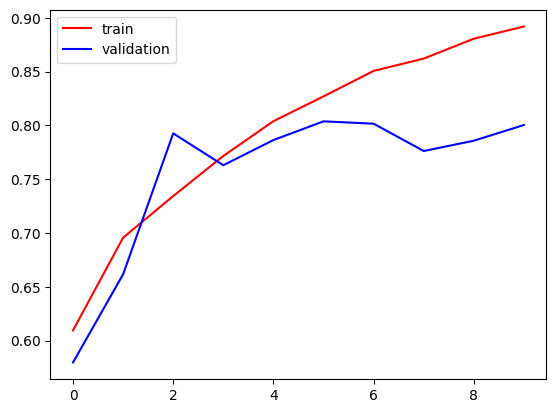

In [29]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'],color='red',label='train')
plt.plot(history.history['val_accuracy'],color='blue',label='validation')
plt.legend()
plt.show()

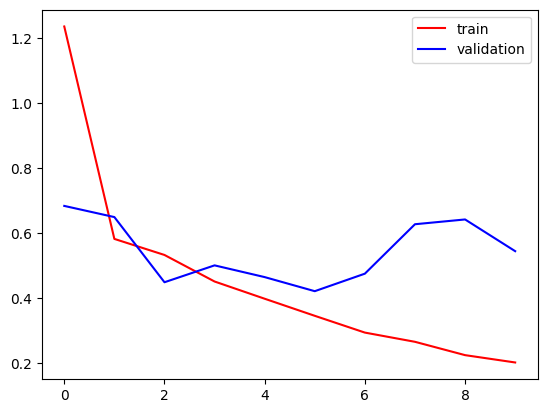

In [32]:
plt.plot(history.history['loss'],color='red',label='train')
plt.plot(history.history['val_loss'],color='blue',label='validation')
plt.legend()
plt.show()

n short:

* Read → Resize → Add batch dimension.

* The final result is in a shape the model can accept: (batch_size, height, width, channels).

Saving cat1.jpeg to cat1 (5).jpeg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Prediction: Cat (Confidence: 0.4589)


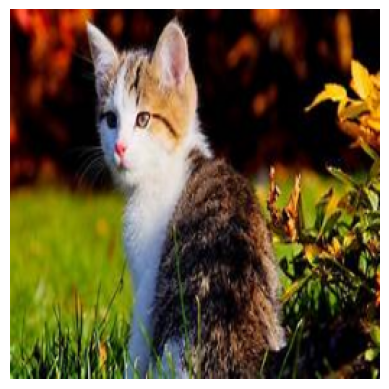

In [52]:
from warnings import WarningMessage
from google.colab import files
import cv2
import numpy as np
import matplotlib.pyplot as plt


def classify_image(model, target_size=(256, 256)):
    """
    Uploads an image, preprocesses it, and predicts using the given model.

    Args:
        model: Trained model for prediction.
        target_size (tuple): Desired (width, height) for resizing the image.
    """

    # Upload image
    uploaded = files.upload()
    image_path = list(uploaded.keys())[0]

    # Read image
    img = cv2.imread(image_path)
    img_resized = cv2.resize(img, target_size)

    # Reshape for model input
    img_reshaped = img_resized.reshape(-1, target_size[0], target_size[1], 3)

    # Predict
    prediction = model.predict(img_reshaped)

    # Output result
    label = "Dog" if prediction[0][0] > 0.5 else "Cat"
    print(f"Prediction: {label} (Confidence: {prediction[0][0]:.4f})")

    # Display image
    img_rgb = cv2.cvtColor(img_resized, cv2.COLOR_BGR2RGB)
    plt.axis('off')
    plt.imshow(img_rgb)
    plt.show()

# Usage:
classify_image(model)
# print(prediction)

In [54]:
model.save("model.h5")
from google.colab import files
files.download("model.h5")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [59]:
# pip install streamlit tensorflow opencv-python pillow